In [21]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from dateutil.parser import parse
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path
from tqdm import tqdm

import os

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [22]:
# opening the zarr_dataset
os.environ["L5KIT_DATA_FOLDER"] = "../../../prediction-dataset/"
#os.environ["L5KIT_DATA_FOLDER"] = "../prediction-sample-dataset/"
cfg = load_config_data("./visualisation_config.yaml")
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

# using EgoDataset interface to extract AV data
rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
print(ego_dataset)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [23]:
# printing the frame ranges that make up each scene
scene_frame_indexes = np.array([[0,0]])
for i in range(len(zarr_dataset.scenes)):
    scene_frame_indexes = np.append(scene_frame_indexes, [[zarr_dataset.scenes[i][0][0], zarr_dataset.scenes[i][0][1]]], axis = 0)
    
scene_frame_indexes = np.delete(scene_frame_indexes, 0, 0)
print(scene_frame_indexes)

[[    0   248]
 [  248   497]
 [  497   746]
 [  746   995]
 [  995  1244]
 [ 1244  1493]
 [ 1493  1742]
 [ 1742  1991]
 [ 1991  2240]
 [ 2240  2489]
 [ 2489  2738]
 [ 2738  2987]
 [ 2987  3236]
 [ 3236  3485]
 [ 3485  3734]
 [ 3734  3983]
 [ 3983  4232]
 [ 4232  4481]
 [ 4481  4730]
 [ 4730  4979]
 [ 4979  5228]
 [ 5228  5477]
 [ 5477  5725]
 [ 5725  5973]
 [ 5973  6221]
 [ 6221  6469]
 [ 6469  6717]
 [ 6717  6965]
 [ 6965  7213]
 [ 7213  7461]
 [ 7461  7709]
 [ 7709  7957]
 [ 7957  8205]
 [ 8205  8453]
 [ 8453  8701]
 [ 8701  8949]
 [ 8949  9197]
 [ 9197  9445]
 [ 9445  9693]
 [ 9693  9941]
 [ 9941 10189]
 [10189 10437]
 [10437 10685]
 [10685 10933]
 [10933 11182]
 [11182 11431]
 [11431 11680]
 [11680 11929]
 [11929 12177]
 [12177 12425]
 [12425 12673]
 [12673 12921]
 [12921 13169]
 [13169 13417]
 [13417 13665]
 [13665 13913]
 [13913 14161]
 [14161 14409]
 [14409 14657]
 [14657 14905]
 [14905 15153]
 [15153 15401]
 [15401 15649]
 [15649 15897]
 [15897 16145]
 [16145 16393]
 [16393 16

In [24]:
dataset = EgoDataset(cfg, zarr_dataset, rast)
position_AV = np.empty((len(dataset), 5), dtype=np.float32)
output = np.empty((len(dataset), 2), dtype=np.float32)

ProgressBar = tqdm(dataset)
for i, data in enumerate(ProgressBar):
    position_AV[i] = [data["centroid"][0], data["centroid"][1], data["yaw"], data["target_velocities"][0][0], data["target_velocities"][0][1]]
    output[i] = [data["target_positions"][0][0], data["target_positions"][0][1]]



100%|██████████| 24838/24838 [04:30<00:00, 91.85it/s] 


In [25]:

inputs = torch.from_numpy(position_AV)
outputs = torch.from_numpy(output)
inputs = inputs.to(device)
outputs = outputs.to(device)

In [26]:
dataset = TensorDataset(inputs, outputs)
val_percent = 0.2
num_rows = len(inputs)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [27]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_ds, batch_size, num_workers = 0)

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,2)
        )
        
    def forward(self, xb):
        out = self.layers(xb)                       
        return out
    
    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.mse_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [29]:
model = NeuralNetwork()
model.to(device)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [30]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [31]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 3633.8994140625}


In [15]:
epochs = 1000
lr = 1e-6
fit(epochs, lr, model, train_loader, val_loader)

KeyboardInterrupt: 

In [32]:
#torch.save(model.state_dict(), 'model.pth')
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))
model.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

f1loss  val_loss = 0.0928 1000 epochs 1e-6 lr  
mseloss val_loss = 0.0183 1000 epochs 1e-6 lr  
mseloss val_loss = 0.0120 10000 epochs 1e-7 lr plateu  

In [33]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    return target, prediction

In [34]:
for i in range(10):
    input, target = val_ds[i]
    print(predict_single(input, target, model))

(tensor([0., 0.]), tensor([ 0.0915, -0.1450]))
(tensor([ 1.1141, -0.0063]), tensor([1.1258, 0.0842]))
(tensor([ 1.2283, -0.0063]), tensor([ 1.3251, -0.1908]))
(tensor([ 0.9610, -0.0102]), tensor([1.0042, 0.0062]))
(tensor([1.1128e+00, 1.2181e-04]), tensor([0.8250, 0.0457]))
(tensor([ 0.4084, -0.0056]), tensor([0.3405, 0.0298]))
(tensor([ 0.6476, -0.0304]), tensor([0.6861, 0.0449]))
(tensor([0.8478, 0.0082]), tensor([ 0.8942, -0.0816]))
(tensor([ 1.1258, -0.0109]), tensor([0.8376, 0.0483]))
(tensor([1.3118, 0.0062]), tensor([ 0.9851, -0.0096]))


In [13]:
targets = []
predictions = []
for i in range(len(val_ds)):
    input, target = val_ds[i]
    target, prediction = predict_single(input, target, model)
    targets.append(target)
    predictions.append(prediction)

xtargets = []
ytargets = []
xpredictions = []
ypredictions = []
for i in range(len(targets)):
    xtargets.append(targets[i][0])
    ytargets.append(targets[i][1])
    xpredictions.append(predictions[i][0])
    ypredictions.append(predictions[i][1])


Text(0.5, 1.0, 'Predictions')

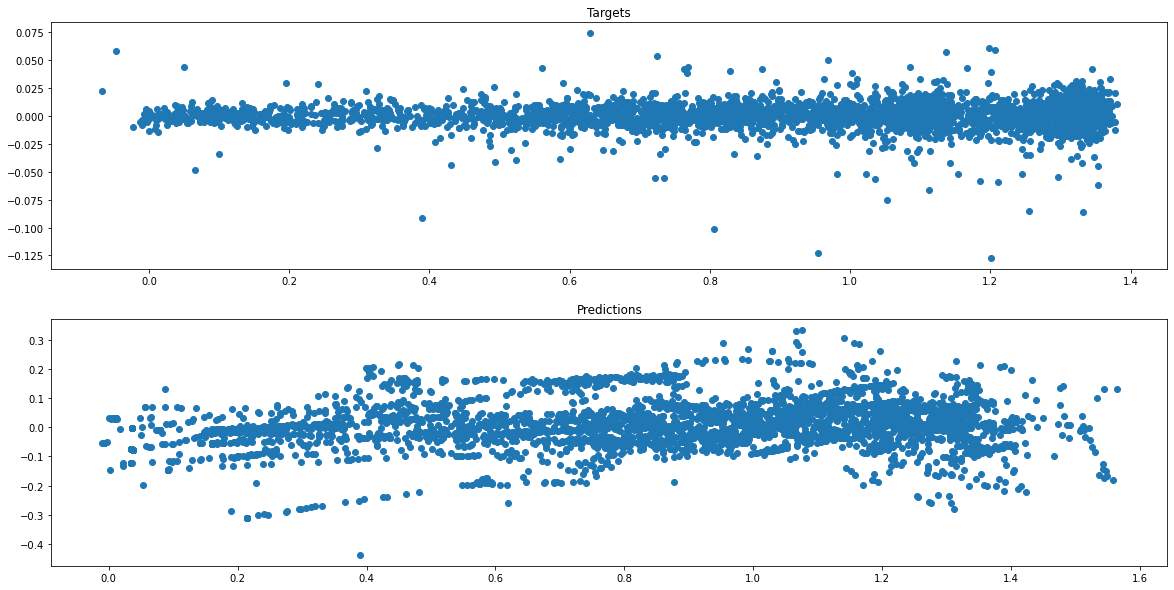

In [14]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(20, 10))
ax1.scatter(xtargets, ytargets)
ax1.set_title("Targets")
ax2.scatter(xpredictions, ypredictions)
ax2.set_title("Predictions")

In [15]:
def get_accuracy(predictx,actualx,predicty,actualy):
        if predictx >= actualx*0.9 and predictx <= actualx*1.1 and predicty >= actualy*0.9 and predicty <= actualy*1.1:
            return 1
        else:
            return 0

In [16]:
count = 0
for i in range(len(predictions)):
    count += get_accuracy(predictions[i][0],targets[i][0],predictions[i][1],targets[i][1])
print(count/len(predictions))

0.0012079726192872962


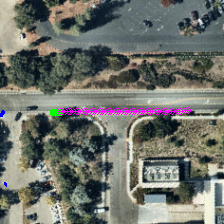

KeyboardInterrupt: 

In [16]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)


for i in range(100):
    scene_idx = i
    indexes = dataset.get_scene_indices(scene_idx)
    images = []
    for idx in indexes:

        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
        clear_output(wait=True)
        display(PIL.Image.fromarray(im))

In [19]:
print(data["target_positions"].shape)
print(len(dataset))

(50, 2)
24838


In [36]:
targets = []
predictions = []
for i in range(len(dataset)):
    input, target = dataset
    target, prediction = predict_single(input, target, model)
    targets.append(target)
    predictions.append(prediction)

ValueError: too many values to unpack (expected 2)